In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import joblib
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

/tmp/ipykernel_799385/547803657.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["main.disorder"], order=df["main.disorder"].value_counts().index, palette="viridis")


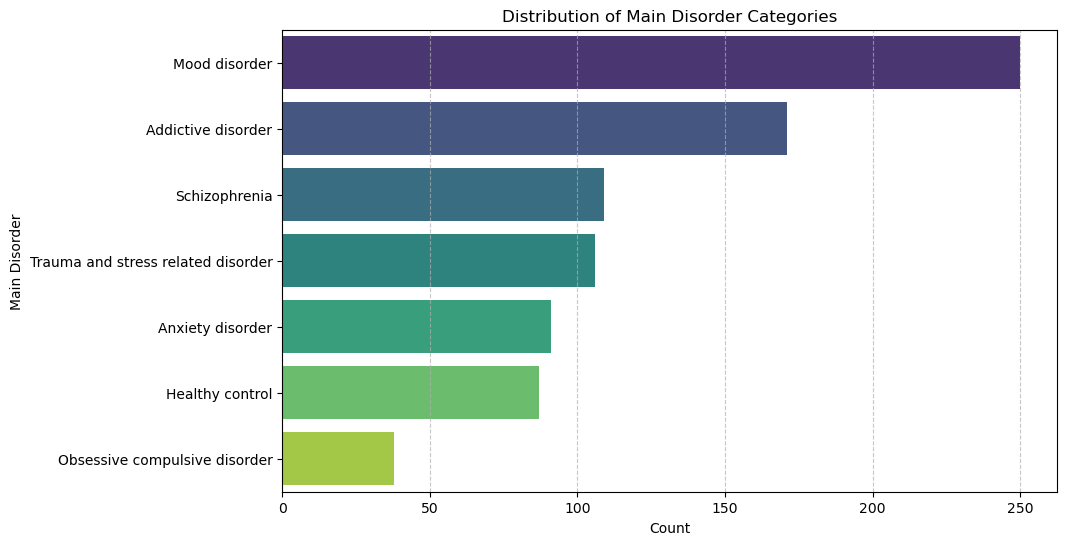

In [2]:
file_path = 'Train_and_Validate_EEG.csv'

df = pd.read_csv(file_path)
# Plot the distribution of main disorders
# Plot the distribution of main disorders
plt.figure(figsize=(10, 6))
sns.countplot(y=df["main.disorder"], order=df["main.disorder"].value_counts().index, palette="viridis")
plt.xlabel("Count")
plt.ylabel("Main Disorder")
plt.title("Distribution of Main Disorder Categories")
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

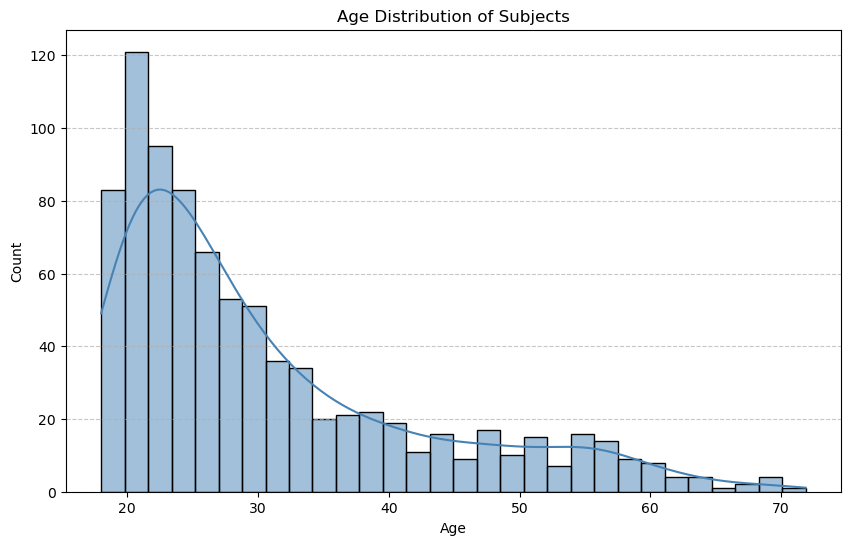

In [3]:
# Plot the distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(df["age"], bins=30, kde=True, color="steelblue")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution of Subjects")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


/tmp/ipykernel_799385/460958033.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["main.disorder"], y=df["age"], palette="coolwarm")


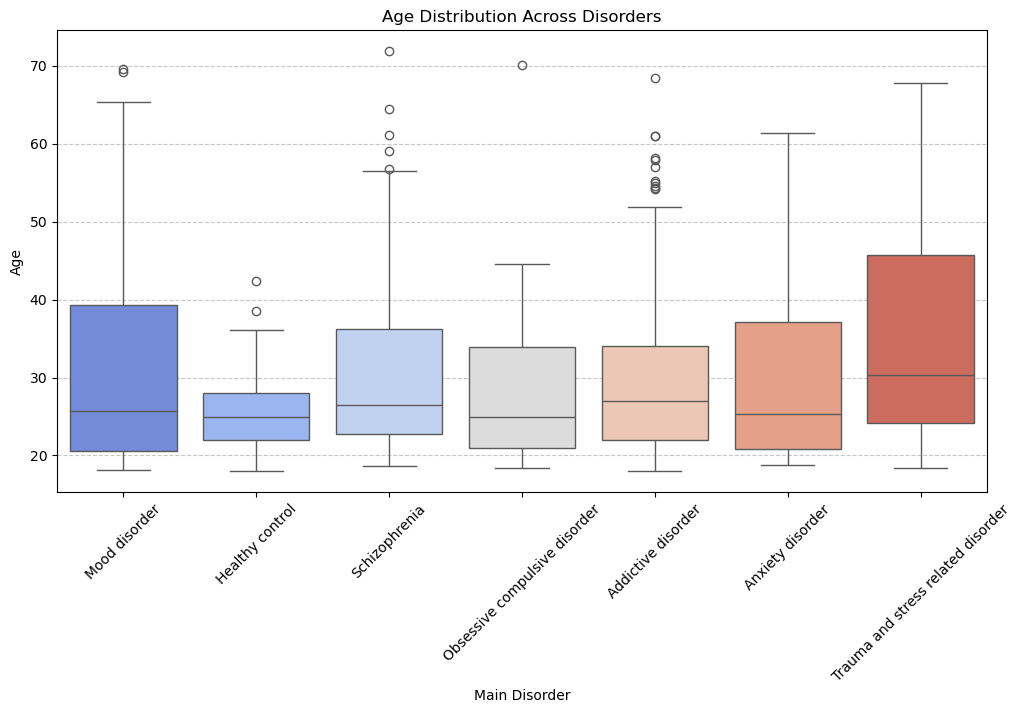

In [4]:
# Plot the distribution of age across different disorders
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["main.disorder"], y=df["age"], palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Main Disorder")
plt.ylabel("Age")
plt.title("Age Distribution Across Disorders")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


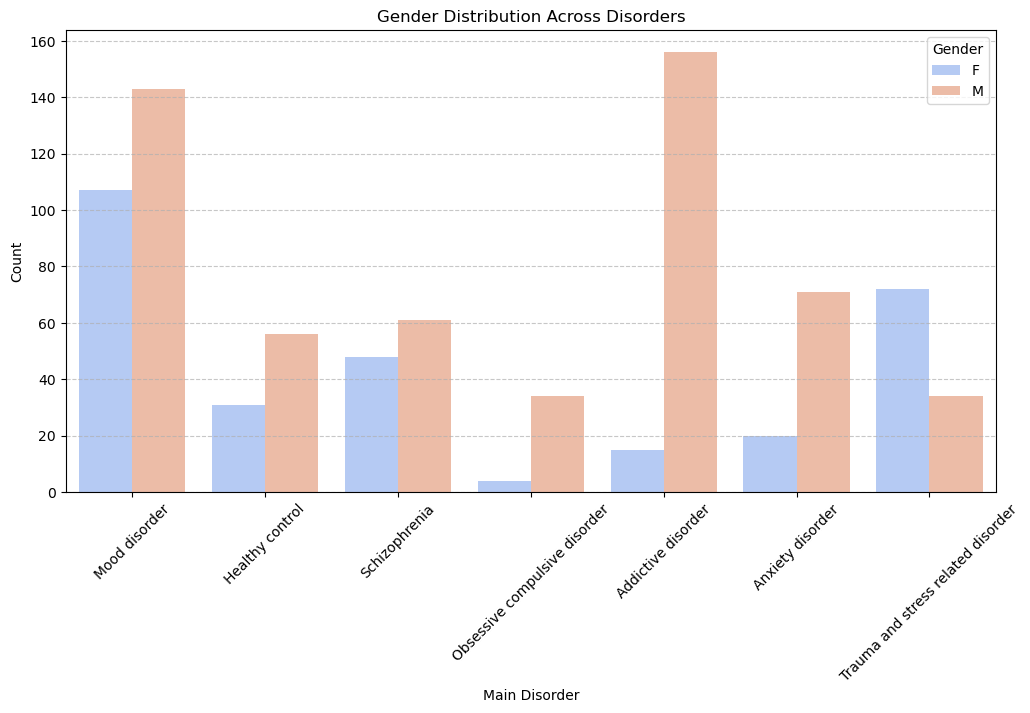

In [5]:
# Plot the distribution of gender across different disorders
plt.figure(figsize=(12, 6))
sns.countplot(x=df["main.disorder"], hue=df["sex"], palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Main Disorder")
plt.ylabel("Count")
plt.title("Gender Distribution Across Disorders")
plt.legend(title="Gender")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


In [6]:
import scipy.stats as stats

# Create a contingency table for gender and main disorder
contingency_table = pd.crosstab(df["main.disorder"], df["sex"])

# Perform chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Display results
chi2, p


(np.float64(129.85113271911356), np.float64(1.3815367847547297e-25))

# Missing data handling
There were 24 rows with missing data. We used KNN imputer for filling the missing values. There were also missing values in the test set, and we used the same knn imputer that was used in the training

Randomly Selected PSD Columns: ['AB.E.highbeta.r.O1', 'AB.D.beta.b.FP2']
Randomly Selected Coherence Columns: ['COH.F.gamma.m.T5.o.Pz', 'COH.B.theta.b.FP2.k.C4']


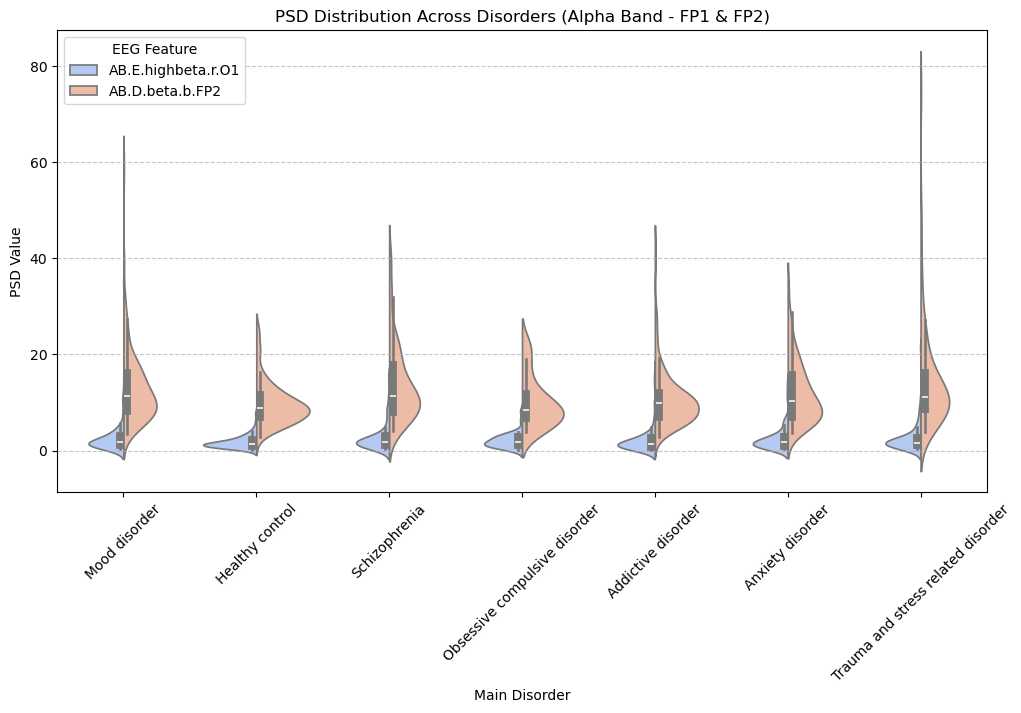

In [11]:
import random


psd_columns = [col for col in df.columns if col.startswith("AB")]
coh_columns = [col for col in df.columns if col.startswith("COH")]

random_psd = random.sample(psd_columns, 2) if len(psd_columns) >= 2 else []
random_coh = random.sample(coh_columns, 2) if len(coh_columns) >= 2 else []


# Print selected columns

# Select a few key EEG features (example: Alpha band from FP1 and FP2 electrodes)
selected_features = random_psd
# Melt the dataframe for visualization
df_melted = df.melt(id_vars=["main.disorder"], value_vars=selected_features, var_name="EEG Feature", value_name="PSD Value")

# Plot violin plots for PSD distribution across disorders
plt.figure(figsize=(12, 6))
sns.violinplot(x="main.disorder", y="PSD Value", hue="EEG Feature", data=df_melted, split=True, palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Main Disorder")
plt.ylabel("PSD Value")
plt.title("PSD Distribution Across Disorders (Alpha Band - FP1 & FP2)")
plt.legend(title="EEG Feature")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


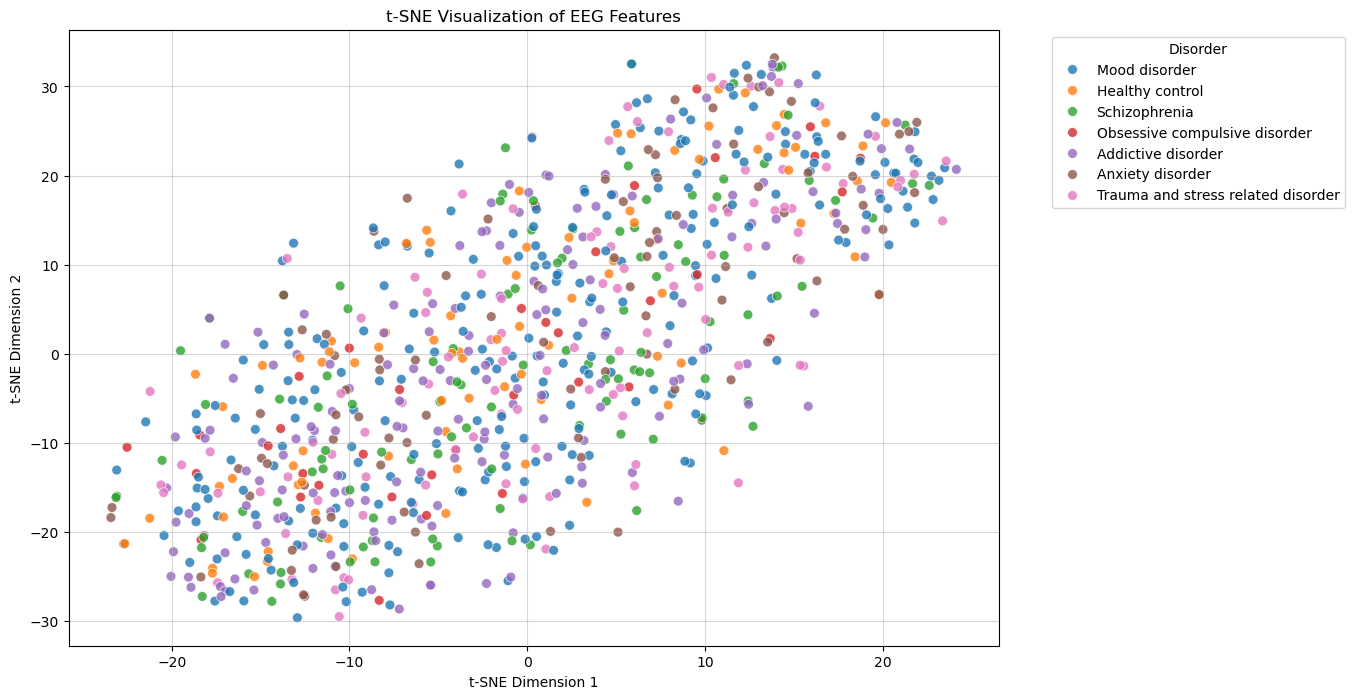

In [14]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
# random_psd_50 = random.sample(psd_columns, 50) if len(psd_columns) >= 50 else psd_columns
# random_coh_50 = random.sample(coh_columns, 50) if len(coh_columns) >= 50 else coh_columns
# Select a subset of PSD and Coherence features for t-SNE (to avoid computational overload)
# selected_features = random_psd_50 + random_coh_50  # First 10 PSD and 10 Coherence features
selected_features = psd_columns + coh_columns
df_selected = df[selected_features].dropna()  # Drop rows with missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_selected)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
tsne_results = tsne.fit_transform(data_scaled)

# Add t-SNE results to a new dataframe
df_tsne = pd.DataFrame(tsne_results, columns=["t-SNE1", "t-SNE2"])
df_tsne["main.disorder"] = df["main.disorder"].loc[df_selected.index].values

# Plot t-SNE results
plt.figure(figsize=(12, 8))
sns.scatterplot(x="t-SNE1", y="t-SNE2", hue="main.disorder", palette="tab10", data=df_tsne, s=50, alpha=0.8)
plt.title("t-SNE Visualization of EEG Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Disorder", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.5)
plt.show()


# Sample dendogram plot

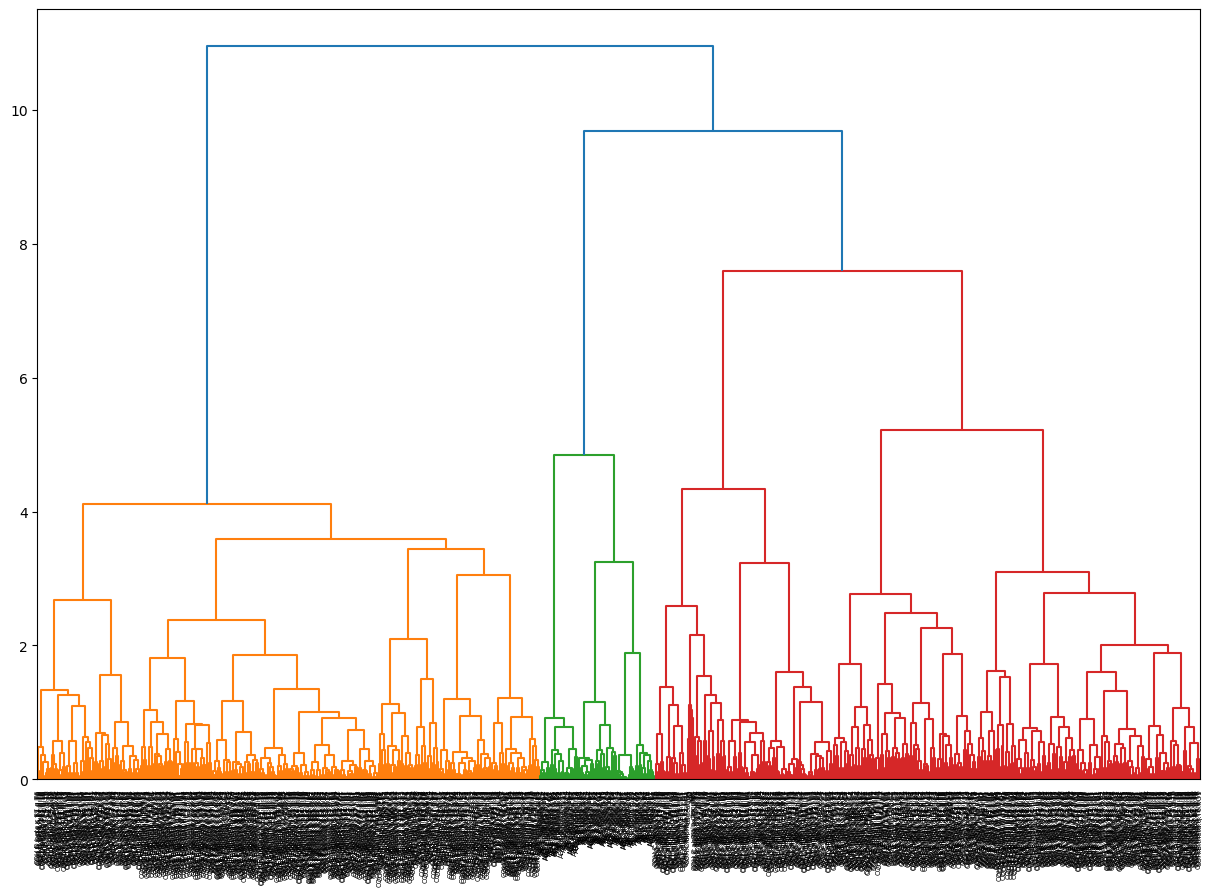

In [1]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy as dc
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

file_path = "Train_and_Validate_EEG.csv"
df = pd.read_csv(file_path)
df = df.drop(columns=["Unnamed: 122","eeg.date","specific.disorder"], errors="ignore")
df = df.dropna()
# Encode 'sex' column
df['sex'] = df['sex'].map({'M': 1, 'F': 0})

# Remove the unnamed column if it exists

variable = "Anxiety disorder"
# Handle missing values: Impute numerical columns with mean
# df.fillna(df.mean(numeric_only=True), inplace=True)

# Define target variable
target_col = "main.disorder"
df = df.dropna(subset=[target_col])  # Drop rows where target is missing



demographic_features = ["ID", "sex", "age", "education", "IQ"]


corr, _ = spearmanr(df, axis=0)

# Ensuring the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert correlation matrix to a distance matrix
distance_matrix = 1 - np.abs(corr)

# Perform hierarchical clustering using Ward's linkage
dist_linkage = hierarchy.ward(squareform(distance_matrix))

# # Outputting shapes for verification
# dist_linkage.shape, data_reshaped.shape

import matplotlib.pyplot as plt


# Plot the dendrogram
fig, ax1 = plt.subplots(figsize=(15, 10))
dendro = hierarchy.dendrogram( dist_linkage, labels=list(df.columns),  # Using feature names from 'mean_std_all' DataFrame
    ax=ax1, leaf_rotation=90)
plt.savefig('dendrogram.png', dpi=600)